In [ ]:
# !pip install git+https://github.com/openai/CLIP.git

## Import Libraries and Check GPU

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import timm
import clip
import os
from tqdm import tqdm
import warnings
import urllib.request  # For downloading images from URLs
import cv2  # For decoding image bytes (OpenCV)
import albumentations as A  # For image transformations
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
    print(f"   PyTorch Version: {torch.__version__}")

    # Set optimal settings for A100
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print("✓ A100 optimizations enabled!")


Using device: cuda
   GPU Name: NVIDIA A100-SXM4-80GB
   GPU Memory: 79.32 GB
   CUDA Version: 12.6
   PyTorch Version: 2.9.0+cu126
✓ A100 optimizations enabled!


## Load Image Metadata

In [ ]:
# Load the preprocessed image embeddings file
print("Loading image metadata...")

image_data = pd.read_csv('preprocessed_image_embeddings.csv')

print(f"✓ Image data loaded successfully!")
print(f"  Total image records: {len(image_data)}")

# Clean URLs from Markdown format [url](url)
print("\nCleaning URLs from Markdown format...")

def extract_url_from_markdown(url_string):
    """Extract clean URL from Markdown link format [url](url)"""
    if pd.isna(url_string):
        return url_string

    url_string = str(url_string)

    # Check if it's in Markdown format [url](url)
    if url_string.startswith('[') and '](' in url_string and url_string.endswith(')'):
        # Extract URL from inside parentheses
        start = url_string.index('](') + 2
        end = url_string.rindex(')')
        clean_url = url_string[start:end]
        return clean_url
    else:
        # Already clean URL
        return url_string

# Apply cleaning to picAddr column
image_data['picAddr'] = image_data['picAddr'].apply(extract_url_from_markdown)

print(f"✓ URLs cleaned!")

print(f"\n  Unique properties: {image_data['ID'].nunique()}")
print(f"  Average images per property: {image_data.groupby('ID').size().mean():.2f}")

print(f"\nColumns: {list(image_data.columns)}")
print(f"\nFirst few cleaned URLs:")
print(image_data[['ID', 'picNo', 'picAddr']].head())


Loading image metadata...
✓ Image data loaded successfully!
  Total image records: 262179

Cleaning URLs from Markdown format...
✓ URLs cleaned!

  Unique properties: 53220
  Average images per property: 4.93

Columns: ['ID', 'picNo', 'picAddr', 'price', 'proType', 'Locality']

First few cleaned URLs:
        ID  picNo                                            picAddr
0  7513227      0  http://i2.au.reastatic.net/800x600/621078f0103...
1  7513227      1  http://i3.au.reastatic.net/800x600/200b273a037...
2  7513227      2  http://i4.au.reastatic.net/800x600/a5bcd73ac0c...
3  7513227      3  http://i1.au.reastatic.net/800x600/e7376bdea81...
4  7513227      4  http://i2.au.reastatic.net/800x600/9f0308b8e8e...


## Analyze Image Availability

In [ ]:
# Analyze image data
print("\n" + "="*80)
print("IMAGE DATA ANALYSIS")
print("="*80)

# Count images per property
images_per_property = image_data.groupby('ID').size()

print(f"\nImages per Property Statistics:")
print(f"  Mean: {images_per_property.mean():.2f}")
print(f"  Median: {images_per_property.median():.0f}")
print(f"  Min: {images_per_property.min()}")
print(f"  Max: {images_per_property.max()}")

print(f"\nDistribution:")
print(f"  Properties with 1-5 images: {(images_per_property <= 5).sum()}")
print(f"  Properties with 6-10 images: {((images_per_property > 5) & (images_per_property <= 10)).sum()}")
print(f"  Properties with 11+ images: {(images_per_property > 10).sum()}")

# Check for missing image paths
print(f"\nData Quality:")
print(f"  Records with missing image paths: {image_data['picAddr'].isnull().sum()}")
print(f"  Records with missing IDs: {image_data['ID'].isnull().sum()}")



IMAGE DATA ANALYSIS

Images per Property Statistics:
  Mean: 4.93
  Median: 5
  Min: 1
  Max: 10

Distribution:
  Properties with 1-5 images: 52795
  Properties with 6-10 images: 425
  Properties with 11+ images: 0

Data Quality:
  Records with missing image paths: 0
  Records with missing IDs: 0


## Load Pre-trained Models - CLIP

In [ ]:
# Load CLIP model (excellent for real estate images)
print("\nLoading CLIP model (ViT-B/32)...")

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

print("✓ CLIP model loaded!")
print(f"  Output embedding size: 512 dimensions")
print(f"  CLIP is specifically good for real estate images!")



Loading CLIP model (ViT-B/32)...


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 233MiB/s]


✓ CLIP model loaded!
  Output embedding size: 512 dimensions
  CLIP is specifically good for real estate images!


## Define Custom Dataset Class

In [ ]:
# Create CLIP-specific Dataset class
class PropertyImageDatasetForCLIP(Dataset):
    def __init__(self, image_dataframe, clip_preprocess, max_images_per_property=None):
        """
        Special dataset for CLIP that uses CLIP's preprocessing
        """
        self.image_df = image_dataframe.copy()
        self.clip_preprocess = clip_preprocess

        if max_images_per_property:
            self.image_df = self.image_df.groupby('ID').head(max_images_per_property).reset_index(drop=True)

        self.image_df = self.image_df.sort_values(['ID', 'picNo']).reset_index(drop=True)

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        img_url = self.image_df.iloc[idx]['picAddr']
        property_id = self.image_df.iloc[idx]['ID']
        pic_no = self.image_df.iloc[idx]['picNo']

        try:
            # Load image from URL
            req = urllib.request.urlopen(img_url, timeout=10)
            arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
            image = cv2.imdecode(arr, cv2.IMREAD_COLOR)

            if image is None:
                raise Exception("Failed to decode image")

            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Convert numpy array to PIL Image (CLIP needs PIL)
            from PIL import Image as PILImage
            pil_image = PILImage.fromarray(image)

            # Apply CLIP preprocessing (expects PIL Image)
            image_tensor = self.clip_preprocess(pil_image)

            return {
                'image': image_tensor,
                'property_id': property_id,
                'pic_no': pic_no,
                'success': True
            }
        except Exception as e:
            if idx % 10 == 0:
                print(f"Error loading image {img_url}: {e}")
            # CLIP expects 3x224x224 tensor
            blank_image = torch.zeros(3, 224, 224)
            return {
                'image': blank_image,
                'property_id': property_id,
                'pic_no': pic_no,
                'success': False
            }

print("✓ CLIP-specific Dataset class defined!")

✓ CLIP-specific Dataset class defined!


## Define Image Transformations

In [ ]:
# A100 GPU can handle large batch sizes
batch_size = 256  # Increase for A100 GPU
num_workers = 4

# Create CLIP-specific dataset with CLIP preprocessing
clip_dataset = PropertyImageDatasetForCLIP(
    image_data,
    clip_preprocess=clip_preprocess,
    max_images_per_property=4
)

clip_dataloader = DataLoader(
    clip_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

## Test Single Image

In [ ]:
print("Testing URL image loading...")

test_sample = clip_dataset[0]
print(f"✓ Successfully loaded test image!")
print(f"  Image shape: {test_sample['image'].shape}")
print(f"  Property ID: {test_sample['property_id']}")
print(f"  Picture number: {test_sample['pic_no']}")
print(f"  Success flag: {test_sample['success']}")

test_url = image_data['picAddr'].iloc[0]
print(f"\nTest URL: {test_url}")
print(f"  Starts with 'http': {test_url.startswith('http')}")
print(f"  Has brackets: {'[' in test_url or ']' in test_url}")


Testing URL image loading...
✓ Successfully loaded test image!
  Image shape: torch.Size([3, 224, 224])
  Property ID: 7513227
  Picture number: 0
  Success flag: True

Test URL: http://i2.au.reastatic.net/800x600/621078f010357f56d62810388e671fed4c10e15bc3eff1dd9aa9ad5a8fe418fb/main.jpg
  Starts with 'http': True
  Has brackets: False


## Extract Features - CLIP

In [ ]:
# Extract features using CLIP (requires different preprocessing)
print("\n" + "="*80)
print("EXTRACTING FEATURES WITH CLIP")
print("="*80)

clip_embeddings = []
property_ids_list_clip = []
pic_nos_list_clip = []
success_list_clip = []

with torch.no_grad():
    for batch in tqdm(clip_dataloader, desc="CLIP Processing"):
        images = batch['image'].to(device)
        property_ids = batch['property_id'].numpy()
        pic_nos = batch['pic_no'].numpy()
        success_flags = batch['success'].numpy()

        # Extract features
        features = clip_model.encode_image(images)
        features = features.float()

        clip_embeddings.append(features.cpu().numpy())
        property_ids_list_clip.append(property_ids)
        pic_nos_list_clip.append(pic_nos)
        success_list_clip.append(success_flags)

# Concatenate all batches
clip_embeddings = np.vstack(clip_embeddings)
property_ids_array_clip = np.concatenate(property_ids_list_clip)
pic_nos_array_clip = np.concatenate(pic_nos_list_clip)
success_array_clip = np.concatenate(success_list_clip)

print(f"\n✓ CLIP features extracted!")
print(f"  Shape: {clip_embeddings.shape}")
print(f"  Embedding dimension: {clip_embeddings.shape[1]}")

num_successful_clip = success_array_clip.sum()
num_failed_clip = len(success_array_clip) - num_successful_clip
success_rate_clip = (num_successful_clip / len(success_array_clip)) * 100

print(f"\n  Successfully loaded images: {num_successful_clip}/{len(success_array_clip)} ({success_rate_clip:.2f}%)")
print(f"  Failed/blank images: {num_failed_clip}/{len(success_array_clip)} ({100-success_rate_clip:.2f}%)")


EXTRACTING FEATURES WITH CLIP


CLIP Processing:   0%|          | 0/818 [00:00<?, ?it/s]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/2Ewv8LvZiww/0.jpg: HTTP Error 404: Not Found


CLIP Processing:   0%|          | 4/818 [00:11<29:46,  2.19s/it]  

Error loading image http://img.youtube.com/vi/m-PSTjidZ4w/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/_1mMnhbHEoo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:   3%|▎         | 28/818 [01:34<35:32,  2.70s/it]  

Error loading image http://img.youtube.com/vi/zV0QyCXU-uw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:   4%|▍         | 34/818 [01:55<39:15,  3.00s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:   5%|▌         | 43/818 [02:27<38:13,  2.96s/it]

Error loading image http://img.youtube.com/vi/wbeXkx995FE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:   7%|▋         | 54/818 [03:10<46:05,  3.62s/it]

Error loading image http://img.youtube.com/vi/l-V4OUlojuk/0.jpg: HTTP Error 404: Not Found


CLIP Processing:   7%|▋         | 60/818 [03:23<30:42,  2.43s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:   8%|▊         | 64/818 [03:34<29:29,  2.35s/it]

Error loading image http://img.youtube.com/vi/mFDRxuQe-Tk/0.jpg: HTTP Error 404: Not Found


CLIP Processing:   9%|▉         | 76/818 [04:05<25:35,  2.07s/it]

Error loading image http://img.youtube.com/vi/QnFrpn18xaQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/x4EXM8BF3wQ/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  10%|▉         | 80/818 [04:26<37:32,  3.05s/it]  

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  10%|█         | 84/818 [04:45<40:30,  3.31s/it]  

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  11%|█         | 86/818 [05:03<59:52,  4.91s/it]

Error loading image http://img.youtube.com/vi/tmko1nOCsnI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  12%|█▏        | 97/818 [06:16<1:24:20,  7.02s/it]

Error loading image http://img.youtube.com/vi/edjmHNtOh0o/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  14%|█▎        | 112/818 [07:09<43:02,  3.66s/it]  

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  14%|█▎        | 112/818 [07:23<43:02,  3.66s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/VWZMJE6P1Og/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  14%|█▍        | 116/818 [07:54<50:56,  4.35s/it]

Error loading image http://img.youtube.com/vi/P-Gc1X_iIDE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  15%|█▍        | 120/818 [07:56<48:28,  4.17s/it]  

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  15%|█▌        | 124/818 [08:15<44:48,  3.87s/it]  

Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/bx8tbgwDk1o/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  16%|█▌        | 127/818 [08:32<51:31,  4.47s/it]

Error loading image http://img.youtube.com/vi/dbWD0QU3WBI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  16%|█▌        | 132/818 [08:44<36:21,  3.18s/it]

Error loading image http://img.youtube.com/vi/-M88byYZlwo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/FFsOA-bfMo0/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  17%|█▋        | 135/818 [08:57<40:06,  3.52s/it]

Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/LOC7wcCpWSM/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  17%|█▋        | 140/818 [09:16<37:25,  3.31s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  17%|█▋        | 140/818 [09:34<37:25,  3.31s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  18%|█▊        | 144/818 [09:38<40:53,  3.64s/it]  

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/8ydsdfQBQm4/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  18%|█▊        | 148/818 [09:56<39:36,  3.55s/it]  

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/UFR_lD_PKuY/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  18%|█▊        | 151/818 [10:10<44:21,  3.99s/it]

Error loading image http://img.youtube.com/vi/7yW2e6VOxCA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  19%|█▉        | 156/818 [10:31<40:03,  3.63s/it]  

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  20%|█▉        | 160/818 [10:47<37:20,  3.40s/it]  

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/T2HS5oStqvo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  20%|█▉        | 163/818 [10:56<34:55,  3.20s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  21%|██        | 168/818 [11:07<26:37,  2.46s/it]

Error loading image http://img.youtube.com/vi/XU4qNyFwmgU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/ng0WLmZ97pY/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  21%|██        | 172/818 [11:24<30:52,  2.87s/it]

Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/aIQhN49rrpc/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  21%|██▏       | 174/818 [11:41<46:27,  4.33s/it]

Error loading image http://img.youtube.com/vi/6S0l5CxYyxk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  22%|██▏       | 180/818 [11:58<33:21,  3.14s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/34dD54tyYU4/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/bx8tbgwDk1o/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  22%|██▏       | 183/818 [12:12<39:18,  3.71s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Zyj5Pfe3QmE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  23%|██▎       | 188/818 [12:24<29:35,  2.82s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/RPRRDpgvHhs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/4vIFUIT5eXo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/qfkCHLWWTyQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Gwqw7J_-DE8/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  23%|██▎       | 191/818 [12:37<34:07,  3.27s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/-TW2ATtorU0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/zySk17tVWD4/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/22SXNY_r_5Y/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  24%|██▍       | 196/818 [12:51<28:42,  2.77s/it]

Error loading image http://img.youtube.com/vi/d5BuvET_RC8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Jor-eCqSS1A/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/LQoxtzvBrJ4/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/5qcWCjxgi4g/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  24%|██▍       | 199/818 [13:02<31:33,  3.06s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/z9RfqlZCVAc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  25%|██▍       | 204/818 [13:11<22:58,  2.25s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/azKIAgVzP7o/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/97HlnirHTS8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/l6HPnXFzXoo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/csPTIq104nU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/UZecSUqICV8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/VN0YFC2Rdbo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Rqpr7GJ51Vo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  25%|██▍       | 204/818 [13:24<22:58,  2.25s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  25%|██▌       | 208/818 [13:27<26:21,  2.59s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  25%|██▌       | 208/818 [13:44<26:21,  2.59s/it]

Error loading image http://img.youtube.com/vi/p3J2i-NALFE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/xJUcx5xIGQE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  26%|██▌       | 212/818 [13:46<31:22,  3.11s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/eUf8Jlgm-6M/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/zcsd_z4wyNw/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/arShIn0zUhI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  26%|██▋       | 215/818 [13:57<33:59,  3.38s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/pDmcGSALRDc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  27%|██▋       | 220/818 [14:07<24:30,  2.46s/it]

Error loading image http://img.youtube.com/vi/TVu5oslfqMc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  27%|██▋       | 222/818 [14:15<27:40,  2.79s/it]

Error loading image http://img.youtube.com/vi/UFR_lD_PKuY/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/p0VtFrpJwPs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WtiMlKeMLKU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/YT_F3MT4FIQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9vxq3b6UOb8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with

CLIP Processing:  28%|██▊       | 228/818 [14:22<17:26,  1.77s/it]

Error loading image http://img.youtube.com/vi/Rbinahq4S4E/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/PsKtJkkO590/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/qG1kMS_AQbM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/q8BvlUkgg8w/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  28%|██▊       | 230/818 [14:30<21:54,  2.24s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/bIZPKMtnuyg/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  29%|██▉       | 236/818 [14:38<15:40,  1.62s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/zqM2iJ-cCRE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/lNrm68YYfCU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/AkoOMe4ow7w/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error 

CLIP Processing:  29%|██▉       | 238/818 [14:48<23:28,  2.43s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/g7pxzXzU3nw/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/BLDWzxdVTU4/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  30%|██▉       | 244/818 [14:58<17:56,  1.88s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  30%|███       | 248/818 [15:14<22:45,  2.40s/it]

Error loading image http://img.youtube.com/vi/xr-f6D796f8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Rhd1vj2acTI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/AZ_liQOzZV8/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  31%|███       | 250/818 [15:33<40:28,  4.27s/it]

Error loading image http://img.youtube.com/vi/BwZKV9leOSM/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  31%|███▏      | 256/818 [15:51<30:05,  3.21s/it]

Error loading image http://img.youtube.com/vi/JcwlGkFXmK0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  31%|███▏      | 256/818 [16:04<30:05,  3.21s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  32%|███▏      | 260/818 [16:06<28:28,  3.06s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/XU4qNyFwmgU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Kp4XQuY9FEs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/GpNnyDTYxnA/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  32%|███▏      | 262/818 [16:21<38:25,  4.15s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  33%|███▎      | 268/818 [16:38<28:25,  3.10s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/JrT1DvSWdv8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/IJpfkrRyFuE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  33%|███▎      | 271/818 [16:52<33:33,  3.68s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/qXSoLi5rGH4/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  34%|███▎      | 276/818 [17:07<27:42,  3.07s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/g3SDRRI4a8I/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/a3tPahwCzLY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/UFR_lD_PKuY/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/bx8tbgwDk1o/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  34%|███▍      | 280/818 [17:26<29:15,  3.26s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/0D3uzsmhf84/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  34%|███▍      | 280/818 [17:44<29:15,  3.26s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  35%|███▍      | 284/818 [17:48<32:46,  3.68s/it]

Error loading image http://img.youtube.com/vi/4pkyyPjzqDY/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/XU4qNyFwmgU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/AZ_liQOzZV8/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  35%|███▌      | 288/818 [18:07<32:37,  3.69s/it]

Error loading image http://img.youtube.com/vi/wvSz6ltHD4Q/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/txSJYIjBQqY/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/4vIFUIT5eXo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  35%|███▌      | 288/818 [18:24<32:37,  3.69s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  36%|███▌      | 292/818 [18:26<31:31,  3.60s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/_cT48FtjiFU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/KKreP9S3AIA/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  36%|███▌      | 295/818 [18:41<36:32,  4.19s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/MWqhjDlSqzI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  37%|███▋      | 300/818 [19:05<34:29,  4.00s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/_y6ZThrL6Is/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/B5FnOXO_o18/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/P2JnJ9jjwNE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/EBhRpK3q-3U/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  37%|███▋      | 300/818 [19:24<34:29,  4.00s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  37%|███▋      | 304/818 [19:26<33:59,  3.97s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/a3l8TwCDzZI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/OdRD0GCgoF0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  38%|███▊      | 307/818 [19:42<37:43,  4.43s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/7jsFFVYcMXc/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/2yxczWklH4c/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/HgfWyxfrGT8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/V3YBXFoZZAs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading im

CLIP Processing:  38%|███▊      | 312/818 [19:54<26:29,  3.14s/it]

Error loading image http://img.youtube.com/vi/JJh2zjDOJD8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/i1tw5mw1xdk/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  39%|███▊      | 315/818 [20:05<27:57,  3.34s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/vmS4sdQhHGY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/ddf_WAbSsFY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic

CLIP Processing:  39%|███▉      | 317/818 [20:17<33:05,  3.96s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  39%|███▉      | 320/818 [20:17<21:48,  2.63s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/-j0T_jUHdK0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/UFR_lD_PKuY/0.jpg: HTTP Error 404: Not Found
Error loading im

CLIP Processing:  39%|███▉      | 323/818 [20:30<26:24,  3.20s/it]

Error loading image http://img.youtube.com/vi/iZFKKZaVj-s/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/vs4UxPoXJw0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/OIu37bv-ce4/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  40%|████      | 328/818 [20:44<21:59,  2.69s/it]

Error loading image http://img.youtube.com/vi/kHxG20xGBKg/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/gCcupBvVThE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  40%|████      | 331/818 [21:03<31:38,  3.90s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  41%|████      | 336/818 [21:21<27:17,  3.40s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/MVUhFSLHNeI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  41%|████▏     | 339/818 [21:33<28:46,  3.60s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/u1o-7nWOMQA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/qLCIk71afJ8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  42%|████▏     | 344/818 [21:45<21:56,  2.78s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/eizTt405E5E/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/uG1pYG3TIok/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  43%|████▎     | 348/818 [22:04<24:44,  3.16s/it]

Error loading image http://img.youtube.com/vi/lGbnnpVHQ_g/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/zcpwdmRAsd8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  43%|████▎     | 348/818 [22:24<24:44,  3.16s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  43%|████▎     | 352/818 [22:24<26:47,  3.45s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/6g8OJEbUpUo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  43%|████▎     | 355/818 [22:41<32:31,  4.21s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  44%|████▍     | 360/818 [22:56<25:01,  3.28s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/BgWtBDKfTHs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  44%|████▍     | 363/818 [23:08<26:53,  3.55s/it]

Error loading image http://img.youtube.com/vi/fiHAXs1w_N0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  45%|████▍     | 368/818 [23:19<19:55,  2.66s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  45%|████▌     | 372/818 [23:36<21:25,  2.88s/it]

Error loading image http://img.youtube.com/vi/shIcTyEahtU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/GpNnyDTYxnA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/QvJsK8O1Hrg/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/oTA3a0Z6Ey8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  46%|████▌     | 375/818 [23:52<28:15,  3.83s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/UMaqeQrWZ5I/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  46%|████▋     | 380/818 [24:05<21:22,  2.93s/it]

Error loading image http://img.youtube.com/vi/0omMCt2ionk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/2KrjCFoQvsc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/pfBEwAzDXR0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  47%|████▋     | 383/818 [24:18<24:37,  3.40s/it]

Error loading image http://img.youtube.com/vi/kF3E2xlprsM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/OLDyyR4F8VQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/VTMDAoVsqUY/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  47%|████▋     | 388/818 [24:31<19:28,  2.72s/it]

Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/sLG-LAmHNQQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/kB-wha_7Lfw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  48%|████▊     | 392/818 [24:44<18:28,  2.60s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  48%|████▊     | 395/818 [25:02<26:41,  3.79s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/UpyUkH2sM9A/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  49%|████▉     | 400/818 [25:21<23:48,  3.42s/it]

Error loading image http://img.youtube.com/vi/0i00sSESxOk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  49%|████▉     | 400/818 [25:34<23:48,  3.42s/it]

Error loading image http://img.youtube.com/vi/5AK2HqWAqOY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  49%|████▉     | 401/818 [25:35<33:58,  4.89s/it]

Error loading image http://img.youtube.com/vi/G7Y2i0rxw60/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  49%|████▉     | 402/818 [26:01<57:59,  8.37s/it]

Error loading image http://img.youtube.com/vi/zqsq2ngcd9U/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/gZXwJ8oHvzM/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  49%|████▉     | 404/818 [26:20<1:00:43,  8.80s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  50%|████▉     | 406/818 [26:41<1:03:43,  9.28s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  50%|████▉     | 407/818 [26:47<1:00:26,  8.82s/it]

Error loading image http://img.youtube.com/vi/7YbXKP0vYdo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  50%|████▉     | 407/818 [27:04<1:00:26,  8.82s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  50%|█████     | 410/818 [27:47<1:30:16, 13.28s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/C-5lLwoyJ6s/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  50%|█████     | 411/818 [27:57<1:26:41, 12.78s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Bngaw37ul_4/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  50%|█████     | 412/818 [28:35<2:04:49, 18.45s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  51%|█████     | 414/818 [28:54<1:40:41, 14.95s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  51%|█████     | 415/818 [29:08<1:38:24, 14.65s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  51%|█████     | 416/818 [29:41<2:08:32, 19.19s/it]

Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/19oJ5Y7fiu0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Vf3Kk9EllzY/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  51%|█████     | 418/818 [30:00<1:41:07, 15.17s/it]

Error loading image http://img.youtube.com/vi/HnZB8pidm4g/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  51%|█████     | 419/818 [30:17<1:43:53, 15.62s/it]

Error loading image http://img.youtube.com/vi/MATIGSloYCE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  51%|█████▏    | 420/818 [30:44<2:02:32, 18.47s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  52%|█████▏    | 422/818 [31:05<1:40:15, 15.19s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  52%|█████▏    | 423/818 [31:18<1:35:57, 14.58s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  52%|█████▏    | 424/818 [31:44<1:54:49, 17.49s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/8zX5R_FrhTQ/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  52%|█████▏    | 426/818 [32:03<1:32:19, 14.13s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/4vIFUIT5eXo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  52%|█████▏    | 427/818 [32:17<1:31:23, 14.02s/it]

Error loading image http://img.youtube.com/vi/TGukpnssQBs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/MZofvm8AH_c/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  53%|█████▎    | 430/818 [33:01<1:28:20, 13.66s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/AICgfdzt8Pg/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/LyU4T4WkWII/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  53%|█████▎    | 431/818 [33:21<1:37:46, 15.16s/it]

Error loading image http://img.youtube.com/vi/AZ_liQOzZV8/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  53%|█████▎    | 434/818 [33:57<1:20:53, 12.64s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  53%|█████▎    | 436/818 [34:43<1:48:23, 17.03s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  54%|█████▎    | 438/818 [34:51<1:14:55, 11.83s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  54%|█████▎    | 438/818 [35:04<1:14:55, 11.83s/it]

Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  54%|█████▎    | 439/818 [35:18<1:36:30, 15.28s/it]

Error loading image http://img.youtube.com/vi/hpbd48DdahQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/GpNnyDTYxnA/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  54%|█████▍    | 440/818 [35:43<1:50:12, 17.49s/it]

Error loading image http://img.youtube.com/vi/fjVLNf4kOEs/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  54%|█████▍    | 442/818 [35:54<1:19:03, 12.62s/it]

Error loading image http://img.youtube.com/vi/3Px9td5vNK8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  54%|█████▍    | 443/818 [36:23<1:41:46, 16.28s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  54%|█████▍    | 444/818 [36:44<1:48:43, 17.44s/it]

Error loading image http://img.youtube.com/vi/qLCIk71afJ8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  55%|█████▍    | 446/818 [36:57<1:19:52, 12.88s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  55%|█████▍    | 447/818 [37:21<1:36:05, 15.54s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  55%|█████▍    | 448/818 [37:45<1:49:06, 17.69s/it]

Error loading image http://img.youtube.com/vi/VrkO3-RAexQ/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  55%|█████▌    | 450/818 [38:02<1:24:48, 13.83s/it]

Error loading image http://img.youtube.com/vi/i89pfMV52W4/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  55%|█████▌    | 451/818 [38:26<1:42:59, 16.84s/it]

Error loading image http://img.youtube.com/vi/2I4JL9KtL4Q/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/qLCIk71afJ8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  55%|█████▌    | 453/818 [38:47<1:18:14, 12.86s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  56%|█████▌    | 454/818 [39:04<1:24:43, 13.96s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  56%|█████▌    | 455/818 [39:34<1:53:40, 18.79s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  56%|█████▌    | 457/818 [39:58<1:25:44, 14.25s/it]

Error loading image http://img.youtube.com/vi/9RlzRBM4338/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/uGU2h1vuvEo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  56%|█████▌    | 458/818 [40:13<1:27:11, 14.53s/it]

Error loading image http://img.youtube.com/vi/vIr6HTFf64Q/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/_yhSlkmNQCs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Xffhy_LddbM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/AelDM_oNJ60/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/GoptECby204/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  56%|█████▌    | 459/818 [40:47<2:01:41, 20.34s/it]

Error loading image http://img.youtube.com/vi/HSVV1mKOJI0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  56%|█████▌    | 460/818 [41:04<1:55:14, 19.31s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  56%|█████▋    | 462/818 [41:18<1:20:45, 13.61s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/qfvRH4uA7X8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  57%|█████▋    | 463/818 [41:51<1:55:33, 19.53s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  57%|█████▋    | 465/818 [42:11<1:23:46, 14.24s/it]

Error loading image http://img.youtube.com/vi/koOH9WRZFGQ/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  57%|█████▋    | 466/818 [42:27<1:26:10, 14.69s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  57%|█████▋    | 467/818 [42:56<1:50:09, 18.83s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/UCutEQXfu-Y/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  57%|█████▋    | 469/818 [43:15<1:18:57, 13.57s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/t01x2UdS4r0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  57%|█████▋    | 470/818 [43:33<1:26:20, 14.89s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/EFFuH8UKYY8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  58%|█████▊    | 471/818 [44:00<1:47:37, 18.61s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  58%|█████▊    | 474/818 [44:30<1:14:35, 13.01s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/eB0Kk_BfrHg/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  58%|█████▊    | 475/818 [45:03<1:47:32, 18.81s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  58%|█████▊    | 478/818 [45:30<1:09:33, 12.28s/it]

Error loading image http://img.youtube.com/vi/9375A2B2MJs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/-XeJMXlQkxE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/0gdf4K03Mlw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  59%|█████▉    | 481/818 [46:23<1:15:11, 13.39s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  59%|█████▉    | 482/818 [46:34<1:09:50, 12.47s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/-EBqORwK1bM/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  59%|█████▉    | 483/818 [47:14<1:55:14, 20.64s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  59%|█████▉    | 486/818 [47:39<1:09:22, 12.54s/it]

Error loading image http://img.youtube.com/vi/XZpA-uyE06Y/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/nWkAwTQw3AE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/GpNnyDTYxnA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  60%|█████▉    | 487/818 [48:24<1:53:10, 20.51s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  60%|█████▉    | 489/818 [48:40<1:18:42, 14.35s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  60%|█████▉    | 490/818 [48:49<1:09:43, 12.75s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/

CLIP Processing:  60%|██████    | 491/818 [49:34<2:00:48, 22.17s/it]

Error loading image http://img.youtube.com/vi/qLCIk71afJ8/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  60%|██████    | 492/818 [49:50<1:49:52, 20.22s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  60%|██████    | 494/818 [49:58<1:09:41, 12.91s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/3Qlb68RU4Zw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  61%|██████    | 498/818 [51:01<1:04:59, 12.19s/it]

Error loading image http://img.youtube.com/vi/iX9kCdnARx8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/oNnZahE9Q0Y/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  61%|██████▏   | 502/818 [52:07<1:03:26, 12.05s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/

CLIP Processing:  61%|██████▏   | 503/818 [52:45<1:34:48, 18.06s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  62%|██████▏   | 506/818 [53:10<58:52, 11.32s/it]  

Error loading image http://img.youtube.com/vi/2OhuAfADTsw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  62%|██████▏   | 507/818 [53:47<1:35:44, 18.47s/it]

Error loading image http://img.youtube.com/vi/1mfI0E-axwA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  62%|██████▏   | 510/818 [54:14<1:01:16, 11.94s/it]

Error loading image http://img.youtube.com/vi/BugfhMWx-hw/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/iP9ahA_AfkU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/hMY70Tow9yk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  62%|██████▏   | 511/818 [54:49<1:29:30, 17.49s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  63%|██████▎   | 514/818 [55:18<59:45, 11.79s/it]  

Error loading image http://img.youtube.com/vi/UAAP3kdk8rw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/wToYBxqMYrY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/m5Eo7UXhbIE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  63%|██████▎   | 515/818 [55:58<1:39:55, 19.79s/it]

Error loading image http://img.youtube.com/vi/NjI-GmPTXq0/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  63%|██████▎   | 517/818 [56:24<1:20:19, 16.01s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/CedV6VtSUjk/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/hwkV9fqh2wg/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  63%|██████▎   | 519/818 [57:09<1:33:46, 18.82s/it]

Error loading image http://img.youtube.com/vi/fc1-1qGQJso/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  64%|██████▎   | 520/818 [57:22<1:26:58, 17.51s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  64%|██████▎   | 521/818 [57:30<1:14:17, 15.01s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/iX9kCdnARx8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  64%|██████▍   | 523/818 [58:09<1:23:18, 16.94s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  64%|██████▍   | 524/818 [58:24<1:20:33, 16.44s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  64%|██████▍   | 525/818 [58:35<1:13:35, 15.07s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/m-_xGlOMm9A/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/GZ8ny-qGkHA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  65%|██████▍   | 528/818 [59:29<1:19:33, 16.46s/it]

Error loading image http://img.youtube.com/vi/fKN4QaMuIEs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  65%|██████▍   | 529/818 [59:43<1:16:04, 15.80s/it]

Error loading image http://img.youtube.com/vi/pC0cB06dLmA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/RPRRDpgvHhs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/AZ_liQOzZV8/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  65%|██████▍   | 531/818 [1:00:21<1:21:50, 17.11s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/6X2T6PJhEdc/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  65%|██████▌   | 533/818 [1:00:55<1:22:08, 17.29s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  66%|██████▌   | 536/818 [1:01:42<1:16:00, 16.17s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/2MUg0A7hc0U/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  66%|██████▌   | 537/818 [1:02:01<1:18:20, 16.73s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  66%|██████▌   | 540/818 [1:02:52<1:16:31, 16.52s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  66%|██████▌   | 541/818 [1:03:12<1:20:57, 17.54s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/tWPpgc-QJCY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/wK2MTF2vUls/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  66%|██████▋   | 543/818 [1:03:52<1:24:48, 18.50s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  67%|██████▋   | 544/818 [1:03:57<1:10:27, 15.43s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/PbX2UPKZL80/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  67%|██████▋   | 545/818 [1:04:24<1:22:52, 18.22s/it]

Error loading image http://img.youtube.com/vi/rbCgN6fUAFg/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/SBm6QQCA0oo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  67%|██████▋   | 547/818 [1:04:56<1:18:35, 17.40s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  67%|██████▋   | 548/818 [1:05:04<1:08:06, 15.14s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  67%|██████▋   | 549/818 [1:05:35<1:25:10, 19.00s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  67%|██████▋   | 551/818 [1:06:11<1:23:23, 18.74s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  67%|██████▋   | 552/818 [1:06:19<1:11:26, 16.11s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  68%|██████▊   | 553/818 [1:06:46<1:23:24, 18.88s/it]

Error loading image http://img.youtube.com/vi/PGt8atV6qx0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  68%|██████▊   | 555/818 [1:07:19<1:18:11, 17.84s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/BocYU-s9Evo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  68%|██████▊   | 557/818 [1:07:49<1:13:10, 16.82s/it]

Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  68%|██████▊   | 559/818 [1:08:28<1:16:41, 17.77s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  68%|██████▊   | 560/818 [1:08:32<1:05:08, 15.15s/it]

Error loading image http://img.youtube.com/vi/iwEgNGhcymQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/pgUak74b4Oo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  69%|██████▊   | 561/818 [1:08:59<1:15:31, 17.63s/it]

Error loading image http://img.youtube.com/vi/coj2dN7KwhU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/RrN65vKJ19g/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic

CLIP Processing:  69%|██████▉   | 564/818 [1:09:36<59:32, 14.07s/it]  

Error loading image http://img.youtube.com/vi/O-tcIFdOdqo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/RsWAR_sCoF0/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  69%|██████▉   | 565/818 [1:10:02<1:11:21, 16.92s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  69%|██████▉   | 567/818 [1:10:43<1:16:58, 18.40s/it]

Error loading image http://img.youtube.com/vi/2-CBkF6OD1Y/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/LyBftI7jmRc/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/HQfh_xxPkno/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9EOW_C5KYxI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  70%|██████▉   | 569/818 [1:11:08<1:07:35, 16.29s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  70%|██████▉   | 572/818 [1:11:55<1:02:28, 15.24s/it]

Error loading image http://img.youtube.com/vi/hZLXSDzTmBI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  70%|███████   | 573/818 [1:12:20<1:10:23, 17.24s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  70%|███████   | 576/818 [1:13:11<1:05:33, 16.25s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  71%|███████   | 577/818 [1:13:34<1:12:00, 17.93s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/

CLIP Processing:  71%|███████   | 579/818 [1:14:17<1:17:02, 19.34s/it]

Error loading image http://img.youtube.com/vi/m77Vw1cbMdY/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  71%|███████   | 580/818 [1:14:21<1:03:05, 15.91s/it]

Error loading image http://img.youtube.com/vi/ZnqWVzv-0v8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  71%|███████   | 581/818 [1:14:45<1:09:51, 17.69s/it]

Error loading image http://img.youtube.com/vi/MT27BOR8n5k/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  71%|███████▏  | 583/818 [1:15:24<1:12:30, 18.51s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  71%|███████▏  | 584/818 [1:15:27<58:55, 15.11s/it]  

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  72%|███████▏  | 585/818 [1:15:48<1:04:19, 16.57s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/

CLIP Processing:  72%|███████▏  | 587/818 [1:16:23<1:04:48, 16.83s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  72%|███████▏  | 588/818 [1:16:28<54:13, 14.14s/it]  

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  72%|███████▏  | 589/818 [1:16:49<1:00:03, 15.74s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/UXm9V9HDXbg/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/-3yiIWBWOvE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  72%|███████▏  | 592/818 [1:17:36<57:21, 15.23s/it]  

Error loading image http://img.youtube.com/vi/fyC7ial8Eig/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  72%|███████▏  | 593/818 [1:17:54<59:51, 15.96s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/iQvZAZkcMDM/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  73%|███████▎  | 595/818 [1:18:35<1:06:19, 17.84s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  73%|███████▎  | 597/818 [1:19:00<58:32, 15.89s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  73%|███████▎  | 599/818 [1:19:35<1:00:12, 16.49s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  73%|███████▎  | 600/818 [1:19:44<54:26, 14.98s/it]  

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  73%|███████▎  | 601/818 [1:20:04<58:12, 16.10s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/OaOQGqIsQX8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/d_Q8PM6WbMc/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  74%|███████▎  | 603/818 [1:20:42<1:01:54, 17.28s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  74%|███████▍  | 604/818 [1:20:49<53:37, 15.03s/it]  

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  74%|███████▍  | 605/818 [1:21:09<57:33, 16.21s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  74%|███████▍  | 609/818 [1:22:22<1:00:58, 17.50s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/kJzGZ52WDQA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  75%|███████▍  | 611/818 [1:23:06<1:06:44, 19.34s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  75%|███████▍  | 612/818 [1:23:19<1:00:54, 17.74s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  75%|███████▍  | 613/818 [1:23:37<1:01:12, 17.91s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  75%|███████▌  | 615/818 [1:24:17<1:03:45, 18.85s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  75%|███████▌  | 616/818 [1:24:24<54:02, 16.05s/it]  

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/mzrJMISD220/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  75%|███████▌  | 617/818 [1:24:38<52:21, 15.63s/it]

Error loading image http://img.youtube.com/vi/55tKP68LAr4/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/ZzgX9iAxbiE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/mnahn_roqBU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/5LFFwslct4Q/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/ocW48gR0H6c/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  76%|███████▌  | 619/818 [1:25:17<57:06, 17.22s/it]

Error loading image http://img.youtube.com/vi/BJwPXidMVMU/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  76%|███████▌  | 620/818 [1:25:27<51:31, 15.62s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/cdg_sIhWwy0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/8S3Y1DMluZ8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  76%|███████▌  | 621/818 [1:25:41<49:44, 15.15s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  76%|███████▌  | 623/818 [1:26:23<57:02, 17.55s/it]

Error loading image http://img.youtube.com/vi/Jw0nRCPSvBg/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  76%|███████▋  | 624/818 [1:26:33<50:56, 15.76s/it]

Error loading image http://img.youtube.com/vi/RnoQF11mvws/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  76%|███████▋  | 625/818 [1:26:50<51:48, 16.10s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  77%|███████▋  | 627/818 [1:27:25<53:05, 16.68s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  77%|███████▋  | 628/818 [1:27:33<46:48, 14.78s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  77%|███████▋  | 629/818 [1:27:55<51:46, 16.44s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  77%|███████▋  | 631/818 [1:28:24<48:51, 15.68s/it]

Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  77%|███████▋  | 632/818 [1:28:32<43:16, 13.96s/it]

Error loading image http://img.youtube.com/vi/AHQ7bEZX58w/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  77%|███████▋  | 633/818 [1:28:54<49:22, 16.01s/it]

Error loading image http://img.youtube.com/vi/Fl5JpdvAKgU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/NVeDP5GBHyM/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  78%|███████▊  | 635/818 [1:29:35<54:19, 17.81s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  78%|███████▊  | 636/818 [1:29:43<47:25, 15.63s/it]

Error loading image http://img.youtube.com/vi/A52IT-sh-MY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  78%|███████▊  | 637/818 [1:30:02<49:22, 16.37s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9qkj27xwgDU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/pW8jF1aUCPw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  78%|███████▊  | 640/818 [1:30:59<50:59, 17.19s/it]

Error loading image http://img.youtube.com/vi/4owVrfE1gWg/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9sk-CER6liw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  78%|███████▊  | 641/818 [1:31:10<46:12, 15.66s/it]

Error loading image http://img.youtube.com/vi/GE7JbNZzfLQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/SpX4NMoV9cU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic

CLIP Processing:  79%|███████▉  | 645/818 [1:32:18<45:04, 15.63s/it]

Error loading image http://img.youtube.com/vi/e8BEkUyVUfU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/FvkdS6QImcI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/gafT47u5FX4/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/LvLdE_LKfEQ/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  79%|███████▉  | 647/818 [1:33:05<53:23, 18.73s/it]

Error loading image http://img.youtube.com/vi/Xum6KHFrx0c/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  79%|███████▉  | 648/818 [1:33:15<47:48, 16.87s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Z-zfn99CR6A/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  79%|███████▉  | 649/818 [1:33:23<41:27, 14.72s/it]

Error loading image http://img.youtube.com/vi/_l9S7wFbYD0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/C9cIzyoaLr4/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  80%|███████▉  | 652/818 [1:34:29<48:48, 17.64s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  80%|███████▉  | 653/818 [1:34:36<41:37, 15.14s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/yD8mdZ_F2zo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  80%|████████  | 655/818 [1:35:23<50:37, 18.64s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  80%|████████  | 656/818 [1:35:31<43:24, 16.08s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  80%|████████  | 657/818 [1:35:41<39:04, 14.56s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/iwSQCqSHN38/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  81%|████████  | 659/818 [1:36:35<52:09, 19.68s/it]

Error loading image http://img.youtube.com/vi/p7xf2HBwxUo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  81%|████████  | 661/818 [1:36:45<35:26, 13.54s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/m7MN2Dx6OJs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/HCg8GTu7HpY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/P99kqXj7bgA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/isX-Yzr2IqI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3

CLIP Processing:  81%|████████  | 663/818 [1:37:42<50:28, 19.54s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  81%|████████▏ | 665/818 [1:37:46<31:28, 12.35s/it]

Error loading image http://img.youtube.com/vi/Cgk0sGis-NA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/2Eroe8aQqxs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic

CLIP Processing:  82%|████████▏ | 667/818 [1:38:41<47:02, 18.69s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  82%|████████▏ | 668/818 [1:38:50<40:40, 16.27s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  82%|████████▏ | 671/818 [1:39:47<43:18, 17.68s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  82%|████████▏ | 672/818 [1:39:57<39:24, 16.19s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/fOIOMrg8aXc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/E7dWNx6w32k/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/QJitDgeB3-s/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/rBpU8_9DBCA/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  83%|████████▎ | 675/818 [1:40:56<42:23, 17.79s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/JuNItKVaPbA/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  83%|████████▎ | 676/818 [1:41:06<38:54, 16.44s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/GnksvtjB5ic/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/pFC4LrkhdnQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic

CLIP Processing:  83%|████████▎ | 680/818 [1:42:16<38:54, 16.92s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/ALqQqpxyeB4/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/VIriiu3YA7k/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Fg3jdTDlJRQ/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  83%|████████▎ | 683/818 [1:43:03<37:01, 16.46s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  84%|████████▎ | 684/818 [1:43:23<37:42, 16.89s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/

CLIP Processing:  84%|████████▍ | 687/818 [1:44:13<36:40, 16.80s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/QT4zTPR-dQM/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  84%|████████▍ | 688/818 [1:44:21<33:17, 15.36s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  84%|████████▍ | 690/818 [1:44:26<24:08, 11.32s/it]

Error loading image http://img.youtube.com/vi/8Z9RMjZ2B7s/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/ZjTWicEo4HI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/xx7wTYOYTHs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/GpNnyDTYxnA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/SYj99eq_kIc/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/8KZoUJQ1Fek/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  84%|████████▍ | 691/818 [1:45:09<36:27, 17.22s/it]

Error loading image http://img.youtube.com/vi/JH1Q5Wz-n-A/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  85%|████████▍ | 693/818 [1:45:20<27:12, 13.06s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/VIHzR_Mull0/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  85%|████████▍ | 694/818 [1:45:32<26:47, 12.96s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/ib2YwHMJu1I/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/TZytyhQJBFk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/S9uz9ZPnzTI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  85%|████████▍ | 695/818 [1:46:14<39:51, 19.44s/it]

Error loading image http://img.youtube.com/vi/UFR_lD_PKuY/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/XU4qNyFwmgU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/eMDE8TQ-ILw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  85%|████████▌ | 697/818 [1:46:32<30:51, 15.30s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  85%|████████▌ | 698/818 [1:46:40<27:26, 13.72s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/o9kOivZ5caY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Bg40TwhaA_U/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  85%|████████▌ | 699/818 [1:47:22<40:14, 20.29s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  86%|████████▌ | 701/818 [1:47:37<29:38, 15.20s/it]

Error loading image http://img.youtube.com/vi/iFCojsdGEvg/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9Nzen13PktI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  86%|████████▌ | 702/818 [1:47:43<25:25, 13.15s/it]

Error loading image http://img.youtube.com/vi/_5a_UXvJUeM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Gk9S3ZYHQB8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/kEHoDP8_Mgs/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  86%|████████▌ | 703/818 [1:48:22<37:11, 19.40s/it]

Error loading image http://img.youtube.com/vi/kU1brgKhnzs/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  86%|████████▌ | 705/818 [1:48:43<29:37, 15.73s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  86%|████████▋ | 707/818 [1:49:26<33:41, 18.22s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  87%|████████▋ | 710/818 [1:49:54<22:22, 12.43s/it]

Error loading image http://img.youtube.com/vi/9DNoGseb_5s/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/stP15zjOjkA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Kqqd5bTkhOU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/nWzGudlZ2xk/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  87%|████████▋ | 711/818 [1:50:34<35:50, 20.10s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  87%|████████▋ | 712/818 [1:50:43<30:00, 16.99s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  87%|████████▋ | 714/818 [1:50:57<20:19, 11.72s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/OwDpk0zLq0c/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/T4hw7DkO8j8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WH021xEbNWc/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/H6Npqbpc7Tk/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/COv2-soTJRA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/qCLkxDl3_Ek/0.jpg: HTTP Error 404:

CLIP Processing:  87%|████████▋ | 715/818 [1:51:40<36:10, 21.07s/it]

Error loading image http://img.youtube.com/vi/RF5s7fSj5PI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/3XlD9Qth4dg/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/qvZ7JIZRUPE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  88%|████████▊ | 716/818 [1:51:50<30:02, 17.67s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  88%|████████▊ | 718/818 [1:52:08<21:10, 12.70s/it]

Error loading image http://img.youtube.com/vi/4vIFUIT5eXo/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/5ZNUjykJygY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Rm3ls7qvHYc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  88%|████████▊ | 719/818 [1:52:50<35:17, 21.39s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  88%|████████▊ | 720/818 [1:53:03<30:49, 18.87s/it]

Error loading image http://img.youtube.com/vi/1p_l8g4skFE/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  88%|████████▊ | 721/818 [1:53:18<28:54, 17.89s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  88%|████████▊ | 722/818 [1:53:25<23:07, 14.46s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/bhm_4m17FG4/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/XK2dIXJyiEs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/0dbZWYhlkWs/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  89%|████████▊ | 724/818 [1:54:12<28:09, 17.97s/it]

Error loading image http://img.youtube.com/vi/QZHlx8LnGlU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/TKU_5YrX0Fg/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  89%|████████▉ | 726/818 [1:54:36<22:26, 14.63s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/ZArdg82ph2E/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/efzGt3brTNs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/cGr8PWAgtTM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/A58HxX8H4_s/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/o4X_K9vyv-s/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  89%|████████▉ | 727/818 [1:55:15<33:12, 21.89s/it]

Error loading image http://img.youtube.com/vi/zdp-GKzCOXE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/kzNVR02RFlw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  89%|████████▉ | 728/818 [1:55:29<29:10, 19.45s/it]

Error loading image http://img.youtube.com/vi/KOPPSNXnaEE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/SBm6QQCA0oo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/m3dGin_3EoI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  89%|████████▉ | 730/818 [1:55:57<23:26, 15.98s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/6qARUjSRbnk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/H8kEsgCD72Q/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  89%|████████▉ | 731/818 [1:56:38<33:50, 23.33s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  89%|████████▉ | 732/818 [1:56:50<28:27, 19.85s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/w2Hjpl9Bwxw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  90%|████████▉ | 733/818 [1:57:15<30:19, 21.41s/it]

Error loading image http://img.youtube.com/vi/jFQxN4m9-SA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/0B_5nU8X4_U/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/9ySXjlmsmaw/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  90%|████████▉ | 736/818 [1:58:02<23:42, 17.34s/it]

Error loading image http://img.youtube.com/vi/Ifu5jeItyxo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/cSRSfLKD7v8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  90%|█████████ | 737/818 [1:58:27<26:12, 19.41s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/v_wXFNCTcTI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/HA_Yy-qdm4E/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  90%|█████████ | 739/818 [1:59:07<25:55, 19.68s/it]

Error loading image http://img.youtube.com/vi/Jf9Kg42Rlac/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/4jnfzuJUG_E/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  90%|█████████ | 740/818 [1:59:14<21:35, 16.61s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/4NLXnGnEnuM/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  91%|█████████ | 741/818 [1:59:46<26:20, 20.53s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/qGHRIEUZNMg/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  91%|█████████ | 744/818 [2:00:26<19:42, 15.97s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/

CLIP Processing:  91%|█████████ | 745/818 [2:01:02<25:37, 21.06s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/5oLm3tMzzhw/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  91%|█████████▏| 748/818 [2:01:42<19:05, 16.37s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  92%|█████████▏| 749/818 [2:02:10<21:57, 19.09s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/QluSlYYLipU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/ECJZ1RJuRQo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WD2qEEshqPY/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  92%|█████████▏| 751/818 [2:02:47<21:05, 18.89s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  92%|█████████▏| 752/818 [2:02:51<17:03, 15.51s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  92%|█████████▏| 753/818 [2:03:18<19:50, 18.32s/it]

Error loading image http://img.youtube.com/vi/hYr4dsytyig/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/K5yhjOXA428/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Zwe2vJWTdGc/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  92%|█████████▏| 755/818 [2:03:54<19:06, 18.21s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  93%|█████████▎| 757/818 [2:04:27<17:49, 17.53s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  93%|█████████▎| 759/818 [2:04:59<16:46, 17.06s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/1b12kLexo38/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  93%|█████████▎| 761/818 [2:05:33<16:15, 17.12s/it]

Error loading image http://img.youtube.com/vi/PS1nsYMw8Eo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/1Flfi_AWqEM/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/3gknJKBZMFU/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/UeVa40p8xCE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Msa7L4IK-Mk/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  93%|█████████▎| 764/818 [2:06:01<11:49, 13.14s/it]

Error loading image http://img.youtube.com/vi/smbrS4eNfi0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/nej4RwqV3ag/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/ZzjBRV2D7pA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  94%|█████████▎| 765/818 [2:06:38<16:09, 18.28s/it]

Error loading image http://img.youtube.com/vi/9kVMcAkEI2o/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/D4zXjzP0Grs/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/6LRNVa-8twI/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  94%|█████████▍| 768/818 [2:07:15<12:08, 14.57s/it]

Error loading image http://img.youtube.com/vi/5bc9Z_MytQE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  94%|█████████▍| 769/818 [2:07:49<15:36, 19.12s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/wvHW_O6cdxU/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  94%|█████████▍| 772/818 [2:08:30<11:41, 15.24s/it]

Error loading image http://img.youtube.com/vi/gY9sG9mQRMc/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/6pnAC51wDR4/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/HAf9FMncP4g/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  94%|█████████▍| 773/818 [2:08:59<13:56, 18.58s/it]

Error loading image http://img.youtube.com/vi/yoYpFsDadfk/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/iTMZgzNCfhc/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/U1M36gqu5lU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/xqXVVpTpAT4/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  95%|█████████▍| 775/818 [2:09:43<14:23, 20.07s/it]

Error loading image http://img.youtube.com/vi/4GXzUkBKvHk/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/Po2yT7F5mKo/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/15p4Gp1N0YY/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  95%|█████████▍| 777/818 [2:10:09<11:56, 17.49s/it]

Error loading image http://img.youtube.com/vi/nXHEp5Bo_SM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/mMGZWkODRF0/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/EQrZwGxBRWY/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/e5KyA0axSgc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  95%|█████████▌| 779/818 [2:11:01<13:17, 20.45s/it]

Error loading image http://img.youtube.com/vi/3uIjib9E9io/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/vew46YiiGPc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/qV41yhunKHA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  95%|█████████▌| 781/818 [2:11:25<10:50, 17.57s/it]

Error loading image http://img.youtube.com/vi/pgNKvR2ETIE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/mJWMq9Bhh4w/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/-yFkCljqpYM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/FD4J3MMe5Eo/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  96%|█████████▌| 783/818 [2:12:13<11:26, 19.62s/it]

Error loading image http://img.youtube.com/vi/pb_HqYl6cdQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/8MBX2Lpz5ik/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/TRb6ckYsw4A/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/L9rRH8BOfa0/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/DUakHBEUz20/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  96%|█████████▌| 785/818 [2:12:34<09:12, 16.75s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/Ft9f85smJMs/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address assoc

CLIP Processing:  96%|█████████▌| 787/818 [2:13:18<09:32, 18.46s/it]

Error loading image http://img.youtube.com/vi/qYPdfImGzeQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/RdKDeuhfc0c/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  96%|█████████▋| 789/818 [2:13:39<07:42, 15.93s/it]

Error loading image http://img.youtube.com/vi/3TB_pJU50q4/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/LllIMd1Beo8/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/lgPyKQsEoJU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/jpOOr_5PB0E/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  97%|█████████▋| 793/818 [2:14:48<06:36, 15.87s/it]

Error loading image http://img.youtube.com/vi/QUtg_voaJT4/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/gia4o3bliwk/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/vYNf5X9P6yE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/ZbVm-yJQ6mQ/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/WBqFJQt5NyA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/URuGYSxxghM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/eqRdTtrbNfA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/k8GWVU3HqvM/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/yLhvlsSnxaE/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/B0qLPdkRB9o/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/XlZ8jMo25Qc/0.jpg: HTTP Error 404: Not Found

CLIP Processing:  97%|█████████▋| 795/818 [2:15:43<07:23, 19.27s/it]

Error loading image http://img.youtube.com/vi/DpSoqgYqUPA/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  98%|█████████▊| 798/818 [2:15:51<04:05, 12.28s/it]

Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/

CLIP Processing:  98%|█████████▊| 802/818 [2:16:55<03:09, 11.87s/it]

Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/vCbSwE_2PVI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/lNdMd8eRwCI/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/HfPMmqUx7uY/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/P1dDwcnm08I/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/6WquI7afXl4/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/AbHi5QIBIxw/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/U_sagHJRVH8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/ydhwKPzzKuA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/jPG1dQccGJU/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/lwLma1c2NS0/0.jpg: HTTP Error 404: Not Found

CLIP Processing:  99%|█████████▊| 806/818 [2:17:58<02:26, 12.22s/it]

Error loading image http://img.youtube.com/vi/GpNnyDTYxnA/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/3omnQMh8aX8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/qYmgme6YW9I/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/8NBaPteo-N8/0.jpg: HTTP Error 404: Not Found
Error loading image http://img.youtube.com/vi/_k6NC5RACbU/0.jpg: HTTP Error 404: Not Found


CLIP Processing:  99%|█████████▉| 810/818 [2:19:06<01:43, 12.95s/it]

Error loading image http://img.youtube.com/vi/waNEEwBh_mc/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/sSZjHpzm1mg/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing:  99%|█████████▉| 811/818 [2:19:58<02:24, 20.61s/it]

Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing: 100%|█████████▉| 814/818 [2:20:10<00:52, 13.13s/it]

Error loading image http://img.youtube.com/vi/DinA3CONCCE/0.jpg: HTTP Error 404: Not Found
Error loading image http://s2.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>
Error loading image http://img.youtube.com/vi/MTs1UqqwL98/0.jpg: HTTP Error 404: Not Found
Error loading image http://s1.rea.reastatic.net/rs/img/mediaviewer_v3/off.png$$3000.813-18: <urlopen error [Errno -5] No address associated with hostname>


CLIP Processing: 100%|██████████| 818/818 [2:21:12<00:00, 10.36s/it]



✓ CLIP features extracted!
  Shape: (209264, 512)
  Embedding dimension: 512

  Successfully loaded images: 196480/209264 (93.89%)
  Failed/blank images: 12784/209264 (6.11%)


## USING CLIP IMAGE EMBEDDINGS ONLY

In [ ]:
# Use CLIP image embeddings only
print("\n" + "="*80)
print("USING CLIP IMAGE EMBEDDINGS ONLY")
print("="*80)

import numpy as np
from sklearn.preprocessing import StandardScaler

# =========================
# 1. Normalize CLIP embeddings
# =========================
scaler_clip = StandardScaler()

clip_normalized = scaler_clip.fit_transform(clip_embeddings)

print("✓ CLIP embeddings normalized")
print(f"  CLIP embedding dimension: {clip_normalized.shape[1]}")

# =========================
# 2. Final image embeddings
# =========================
# Since we only use CLIP, these are the final embeddings
final_image_embeddings = clip_normalized

print("\n✓ Final image embeddings ready")
print(f"  Shape: {final_image_embeddings.shape}")



USING CLIP IMAGE EMBEDDINGS ONLY
✓ CLIP embeddings normalized
  CLIP embedding dimension: 512

✓ Final image embeddings ready
  Shape: (209264, 512)


## Aggregate Embeddings per Property

In [ ]:
# Aggregate CLIP image embeddings per property
print("\n" + "="*80)
print("AGGREGATING CLIP EMBEDDINGS PER PROPERTY")
print("="*80)

import pandas as pd

# =========================
# 1. Create DataFrame with CLIP embeddings
# =========================
clip_embeddings_df = pd.DataFrame()
clip_embeddings_df['ID'] = property_ids_array_clip
clip_embeddings_df['picNo'] = pic_nos_array_clip

# Add CLIP embedding dimensions
for i in range(final_image_embeddings.shape[1]):
    clip_embeddings_df[f'img_clip_{i}'] = final_image_embeddings[:, i]

print("✓ CLIP embeddings DataFrame created")
print(f"  Shape: {clip_embeddings_df.shape}")

# =========================
# 2. Aggregate per property
# =========================
print("\nAggregating CLIP embeddings per property...")

clip_cols = [col for col in clip_embeddings_df.columns if col.startswith('img_clip_')]

# Mean pooling (recommended)
property_clip_embeddings_mean = (
    clip_embeddings_df
    .groupby('ID')[clip_cols]
    .mean()
    .reset_index()
)

# Max pooling (optional comparison)
property_clip_embeddings_max = (
    clip_embeddings_df
    .groupby('ID')[clip_cols]
    .max()
    .reset_index()
)

print("✓ Property-level CLIP embeddings aggregated!")
print(f"  Mean pooled shape: {property_clip_embeddings_mean.shape}")
print(f"  Max pooled shape: {property_clip_embeddings_max.shape}")



AGGREGATING CLIP EMBEDDINGS PER PROPERTY
✓ CLIP embeddings DataFrame created
  Shape: (209264, 514)

Aggregating CLIP embeddings per property...
✓ Property-level CLIP embeddings aggregated!
  Mean pooled shape: (53220, 513)
  Max pooled shape: (53220, 513)


## Save Combined Embeddings (Main Output)

In [ ]:
# Save CLIP-based property image embeddings
print("\nSaving CLIP image embeddings...")

# =========================
# Save mean pooled embeddings (RECOMMENDED)
# =========================
property_clip_embeddings_mean.to_csv(
    'property_image_embeddings.csv',
    index=False
)

print("✓ MAIN FILE: property_image_embeddings.csv saved!")
print(f"  Shape: {property_clip_embeddings_mean.shape}")
print(f"  Embedding dimensions: {property_clip_embeddings_mean.shape[1] - 1}")  # excluding ID



Saving CLIP image embeddings...
✓ MAIN FILE: property_image_embeddings.csv saved!
  Shape: (53220, 513)
  Embedding dimensions: 512


## Visualize Image Embeddings


Visualizing CLIP image embeddings...
  Total properties: 53220
  Embedding dimension: 512


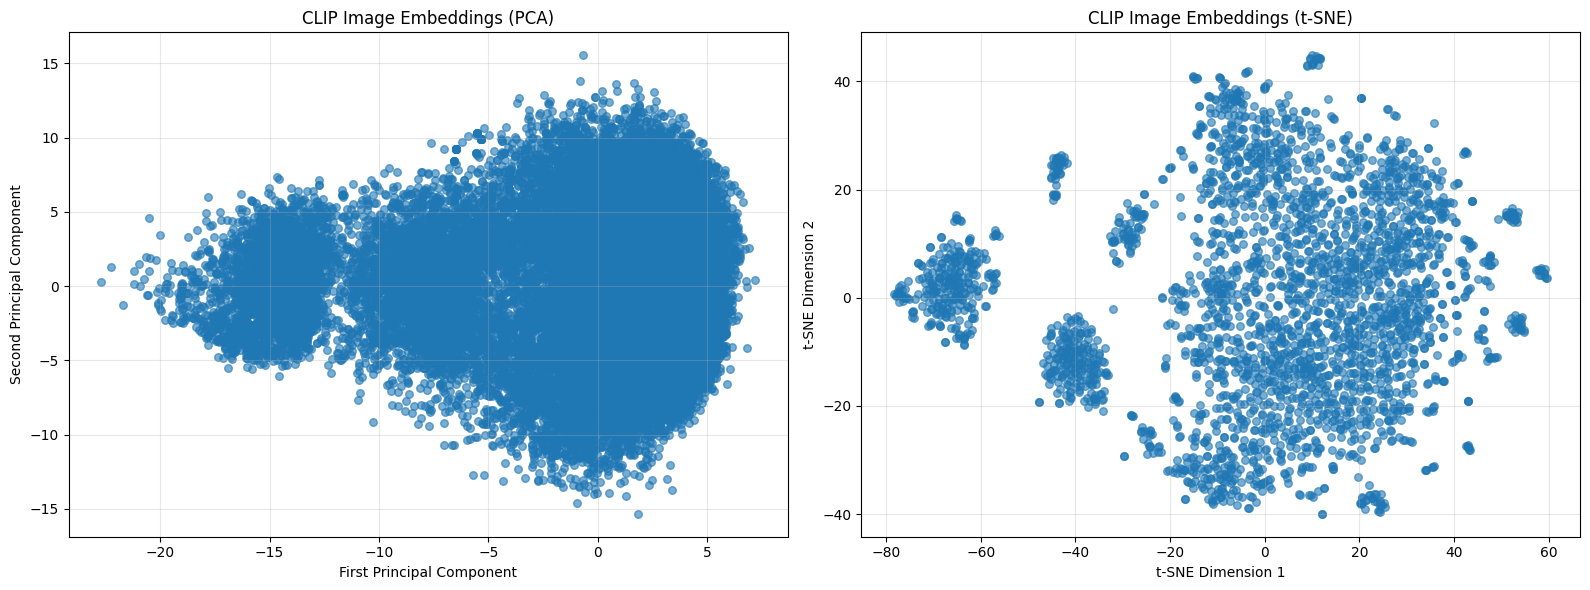

✓ Visualization saved as 'clip_image_embeddings_visualization.png'
  PCA explained variance (2 components): 23.91%


In [ ]:
# Visualize CLIP image embeddings
print("\nVisualizing CLIP image embeddings...")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# =========================
# Select embeddings to visualize
# =========================
# Use mean-pooled CLIP embeddings (property-level)
clip_cols = [col for col in property_clip_embeddings_mean.columns if col.startswith('img_clip_')]
embeddings_to_viz = property_clip_embeddings_mean[clip_cols].values

print(f"  Total properties: {embeddings_to_viz.shape[0]}")
print(f"  Embedding dimension: {embeddings_to_viz.shape[1]}")

# =========================
# PCA (2D)
# =========================
pca_viz = PCA(n_components=2, random_state=42)
embeddings_2d_pca = pca_viz.fit_transform(embeddings_to_viz)

# =========================
# t-SNE (sample if large)
# =========================
if len(embeddings_to_viz) > 3000:
    sample_idx = np.random.choice(len(embeddings_to_viz), 3000, replace=False)
    tsne_input = embeddings_to_viz[sample_idx]
else:
    tsne_input = embeddings_to_viz

tsne_viz = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    init='pca',
    learning_rate='auto'
)
embeddings_2d_tsne = tsne_viz.fit_transform(tsne_input)

# =========================
# Plot
# =========================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
axes[0].scatter(
    embeddings_2d_pca[:, 0],
    embeddings_2d_pca[:, 1],
    alpha=0.6,
    s=30
)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('CLIP Image Embeddings (PCA)')
axes[0].grid(True, alpha=0.3)

# t-SNE plot
axes[1].scatter(
    embeddings_2d_tsne[:, 0],
    embeddings_2d_tsne[:, 1],
    alpha=0.6,
    s=30
)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].set_title('CLIP Image Embeddings (t-SNE)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clip_image_embeddings_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'clip_image_embeddings_visualization.png'")
print(f"  PCA explained variance (2 components): {pca_viz.explained_variance_ratio_.sum():.2%}")


## Calculate Embedding Statistics

In [ ]:
# Calculate statistics for CLIP image embeddings
print("\n" + "="*80)
print("CLIP IMAGE EMBEDDINGS STATISTICS")
print("="*80)

# =========================
# Dataset overview
# =========================
print("\nDataset Overview:")
print(f"  Total images processed: {len(property_ids_array_clip)}")
print(f"  Unique properties: {property_clip_embeddings_mean['ID'].nunique()}")
print(
    f"  Average images per property: "
    f"{len(property_ids_array_clip) / property_clip_embeddings_mean['ID'].nunique():.2f}"
)

# =========================
# Model information
# =========================
print("\nModel Used:")
print("  ✓ CLIP ViT-B/32")
print("    Embedding dimension: 512")

# =========================
# Embedding dimensions
# =========================
clip_cols = [c for c in property_clip_embeddings_mean.columns if c.startswith('img_clip_')]

print("\nEmbedding Dimensions:")
print(f"  Property-level CLIP embeddings: {len(clip_cols)} dims")

# =========================
# Embedding distribution statistics
# =========================
print("\nEmbedding Distribution (CLIP, mean pooled):")
embeddings_array = property_clip_embeddings_mean[clip_cols].values

print(f"  Mean: {embeddings_array.mean():.4f}")
print(f"  Std: {embeddings_array.std():.4f}")
print(f"  Min: {embeddings_array.min():.4f}")
print(f"  Max: {embeddings_array.max():.4f}")

# =========================
# Processing performance
# =========================
print("\nProcessing Performance:")
print(f"  Batch size used: {batch_size}")
print(f"  Device: A100 GPU (Colab Pro Plus)")
print(f"  Total images processed: {len(property_ids_array_clip):,}")



CLIP IMAGE EMBEDDINGS STATISTICS

Dataset Overview:
  Total images processed: 209264
  Unique properties: 53220
  Average images per property: 3.93

Model Used:
  ✓ CLIP ViT-B/32
    Embedding dimension: 512

Embedding Dimensions:
  Property-level CLIP embeddings: 512 dims

Embedding Distribution (CLIP, mean pooled):
  Mean: -0.0002
  Std: 0.6374
  Min: -7.7269
  Max: 6.9310

Processing Performance:
  Batch size used: 256
  Device: A100 GPU (Colab Pro Plus)
  Total images processed: 209,264


## Save Model Information

In [ ]:
# Save CLIP model and processing information
import json

model_info = {
    'models_used': {
        'clip_vit_b32': {
            'output_dim': int(clip_embeddings.shape[1]),  # 512
            'pretrained': 'OpenAI CLIP'
        }
    },
    'processing': {
        'batch_size': batch_size,
        'max_images_per_property': 4,
        'aggregation_method': 'mean',
        'normalization': 'StandardScaler',
        'device': str(device)
    },
    'output': {
        'property_embedding_dim': len(
            [c for c in property_clip_embeddings_mean.columns if c.startswith('img_clip_')]
        ),
        'total_properties': int(property_clip_embeddings_mean['ID'].nunique()),
        'total_images_processed': int(len(property_ids_array_clip))
    }
}

with open('image_embedding_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print("✓ Model information saved to 'image_embedding_info.json'")
print("\nModel Info:")
print(json.dumps(model_info, indent=2))


✓ Model information saved to 'image_embedding_info.json'

Model Info:
{
  "models_used": {
    "clip_vit_b32": {
      "output_dim": 512,
      "pretrained": "OpenAI CLIP"
    }
  },
  "processing": {
    "batch_size": 256,
    "max_images_per_property": 4,
    "aggregation_method": "mean",
    "normalization": "StandardScaler",
    "device": "cuda"
  },
  "output": {
    "property_embedding_dim": 512,
    "total_properties": 53220,
    "total_images_processed": 209264
  }
}


## Create Summary Report

In [ ]:
# Create comprehensive summary (CLIP-only)
print("\n" + "="*80)
print("CLIP IMAGE EMBEDDINGS CREATION - SUMMARY REPORT")
print("="*80)

print("\nIMAGE EMBEDDINGS SUCCESSFULLY GENERATED!")

# =========================
# Processing summary
# =========================
print("\nProcessing Summary:")
print(f"  Total images processed: {len(property_ids_array_clip):,}")
print(f"  Properties with embeddings: {property_clip_embeddings_mean['ID'].nunique():,}")
print("  Aggregation method: Mean pooling across property images")

# =========================
# Model & architecture
# =========================
print("\nModel & Architecture:")
print("  ✓ CLIP ViT-B/32")
print("  ✓ Pretrained on large-scale image–text pairs")
print(f"  ✓ Optimized for A100 GPU (batch size: {batch_size})")
print("  ✓ Strong semantic alignment with textual features")

# =========================
# Main output files
# =========================
print("\nMain Output Files:")
print("  ✓ property_image_embeddings.csv (RECOMMENDED)")
print(f"     Shape: {property_clip_embeddings_mean.shape}")
print(f"     Embedding dimensions: {property_clip_embeddings_mean.shape[1] - 1}")
print(
    f"     Size: "
    f"{os.path.getsize('property_image_embeddings.csv') / 1024 / 1024:.2f} MB"
)

# =========================
# Quality statistics
# =========================
clip_cols = [c for c in property_clip_embeddings_mean.columns if c.startswith('img_clip_')]
embeddings_array = property_clip_embeddings_mean[clip_cols].values

print("\nQuality Metrics:")
print(f"  Mean embedding magnitude: {np.linalg.norm(embeddings_array, axis=1).mean():.2f}")
print(f"  Embedding variance: {embeddings_array.var():.4f}")

# =========================
# Next steps
# =========================
print("\nNext Steps:")
print("  → Combine CLIP image embeddings with text embeddings")
print("  → Integrate with graph-based spatial embeddings")
print("  → Train final multimodal property price prediction model")
print("  → Evaluate performance and conduct ablation studies")

print("\n" + "="*80)
print("CLIP IMAGE EMBEDDING GENERATION COMPLETE!")
print("="*80)

print(
    "\nRecommendation: Use 'property_image_embeddings.csv' "
    "as the visual modality input for the final model."
)



CLIP IMAGE EMBEDDINGS CREATION - SUMMARY REPORT

IMAGE EMBEDDINGS SUCCESSFULLY GENERATED!

Processing Summary:
  Total images processed: 209,264
  Properties with embeddings: 53,220
  Aggregation method: Mean pooling across property images

Model & Architecture:
  ✓ CLIP ViT-B/32
  ✓ Pretrained on large-scale image–text pairs
  ✓ Optimized for A100 GPU (batch size: 256)
  ✓ Strong semantic alignment with textual features

Main Output Files:
  ✓ property_image_embeddings.csv (RECOMMENDED)
     Shape: (53220, 513)
     Embedding dimensions: 512
     Size: 289.95 MB

Quality Metrics:
  Mean embedding magnitude: 14.03
  Embedding variance: 0.4063

Next Steps:
  → Combine CLIP image embeddings with text embeddings
  → Integrate with graph-based spatial embeddings
  → Train final multimodal property price prediction model
  → Evaluate performance and conduct ablation studies

CLIP IMAGE EMBEDDING GENERATION COMPLETE!

Recommendation: Use 'property_image_embeddings.csv' as the visual modalit

## Memory Cleanup

In [ ]:
# Clean up GPU memory
import gc

print("\nCleaning up GPU memory...")

# Delete models
del resnet50
del efficientnet
del vit_model
del clip_model

# Delete embeddings
del resnet_embeddings
del efficientnet_embeddings
del vit_embeddings
del clip_embeddings

# Garbage collection
gc.collect()
torch.cuda.empty_cache()

print("✓ GPU memory cleaned!")

# Check remaining memory
if torch.cuda.is_available():
    print(f"  GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"  GPU memory cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


## Summary
You've successfully created image embeddings using 4 state-of-the-art models optimized for your A100 GPU !​

Models Used:

1. CLIP (512 dims) - Multimodal model excellent for real estate​

Main Output File:

- property_image_embeddings.csv - USE THIS for Step 5 (512 dimensions)

A100 Optimizations Applied:

- Large batch size (128)

- TF32 enabled for faster training

- Efficient memory management

Next Step:

- Step 5: Combine graph embeddings (64D) + text embeddings (768D) + image embeddings (512D) → Train final prediction model!